[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2015-11-23 A        37.476845   40.029999   40.070000   39.139999   39.290001   
           AAL      40.423805   42.299999   42.740002   41.810001   42.110001   
           AAPL     26.799692   29.437500   29.932501   29.334999   29.817499   
           ABBV     43.283794   61.150002   61.529999   60.840000   61.310001   
           ABT      39.117050   45.439999   46.099998   45.259998   46.029999   
...                       ...         ...         ...         ...         ...   
2023-11-17 YUM     127.660004  127.660004  128.490005  127.250000  128.419998   
           ZBH     111.669998  111.669998  112.660004  111.330002  112.349998   
           ZBRA    218.020004  218.020004  218.699997  215.270004  218.460007   
           ZION     36.070000   36.070000   36.470001   35.400002   36.250000   
           ZTS     174.800003  174.800003  177.699997  173.699997  177.410004   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-11-23 A         6473400.0         -0.000587        NaN       NaN   
           AAL       4166100.0         -0.000403        NaN       NaN   
           AAPL    129930000.0         -0.004195        NaN       NaN   
           ABBV      6405000.0         -0.046762        NaN       NaN   
           ABT       4593800.0         -0.010061        NaN       NaN   
...                        ...               ...        ...       ...   
2023-11-17 YUM       1089600.0          0.000033  62.631823  4.773267   
           ZBH       2991400.0          0.000056  60.522122  4.624680   
           ZBRA       340600.0          0.000123  54.353061  5.288684   
           ZION      2136200.0          0.000434  62.590903  3.363988   
           ZTS       2425100.0          0.000174  59.645233  5.028469   

                     bb_mid   bb_high       atr  
date       ticker                                
2015-11-23 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2023-11-17 YUM     4.825134  4.877001  0.260317  
           ZBH     4.676700  4.728720 -0.169064  
           ZBRA    5.341634  5.394584  0.022400  
           ZION    3.506311  3.648633  0.016200  
           ZTS     5.112979  5.197488  1.016106  

[994335 rows x 12 columns]

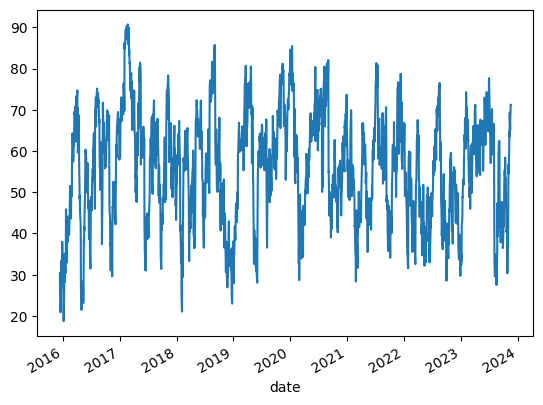

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


sp500 = pd.read_html ('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()
# symbols_list
end_date = '2023-11-19'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
df.index.names = ['date','ticker']
#df
df.columns = df.columns.str.lower()
#df
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
# garman klass volatility: estimator that incorporates open, low, high, and close prices of a security
# 
# df
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, Length=20))
# df
# relative strength index: is a momentum oscillator
# measures the speed and change of price movements.
# RSI oscillates between zero and 100.
# Traditionally RSI is considered overbought when above 70
# and oversold when below 30
# RSI also used to identify general trends
df.xs('AAPL', level=1)['rsi'].plot()
# rsi or relative strength index of Apple
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
df
# Bollinger Bands : consists of a middle band (which is a moving average)
# These upper and lower bands are set above and below the moving average 
# by a certain number of standard deviations of price, thus incorporating volatility

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
#df
# ATR is very useful for stops or entry triggers, signaling changes in volatility.
